In [1]:
#CREMA-D

# IMPORT

In [2]:

import os
from collections import Counter

import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

import random

from src.preprocessing.dataset import (
    list_cremad_files,
    CremadDataset,
    extract_cremad_label_idx,
    CREMA_IDX2LABEL,
)

from src.models.crnn import CRNN
from src.utils import set_seed, evaluate

from sklearn.metrics import confusion_matrix, classification_report



# DEFINIZIONE DATA BASE CREMA-D

In [8]:

set_seed(42)

DATA_ROOT = "./data_cremad"
EPOCHS = 50
BATCH_SIZE = 64
LR = 1e-3
WEIGHT_DECAY = 1e-4

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# 1) lista file
all_files = list_cremad_files(DATA_ROOT)

if len(all_files) == 0:
    raise RuntimeError("Nessun file trovato. Controlla DATA_ROOT e filter_audio_speech().")

# 2) labels per stratify
labels = [extract_cremad_label_idx(fp) for fp in all_files]

print("Tot files:", len(all_files))
print("Distribuzione classi:", Counter(labels))


Device: cuda
Tot files: 7442
Distribuzione classi: Counter({3: 1271, 5: 1271, 4: 1271, 1: 1271, 2: 1271, 0: 1087})


# SPLIT DATASET

In [4]:
# serve per vedere se stai usando la CPU o se hai CUDA
import torch
print("CUDA available:", torch.cuda.is_available())
print("Device count:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device())
print("GPU name:", torch.cuda.get_device_name(0))

# IMPORTANTE
# se qui la prima riga ti ritorna True allora sotto quando scrivi i DataLoader metti i pinmemory = True

CUDA available: True
Device count: 1
Current device: 0
GPU name: NVIDIA GeForce RTX 4060 Laptop GPU


In [5]:
# SI PER CREMA D
from src.preprocessing.dataset import parse_cremad_filename

def split_cremad_by_speaker(files, train_ratio=0.7, val_ratio=0.1):
    speakers = list(set(parse_cremad_filename(f)["speaker"] for f in files))
    random.shuffle(speakers)

    n = len(speakers)
    train_spk = speakers[:int(n*train_ratio)]
    val_spk   = speakers[int(n*train_ratio):int(n*(train_ratio+val_ratio))]
    test_spk  = speakers[int(n*(train_ratio+val_ratio)):]

    train, val, test = [], [], []
    for f in files:
        s = parse_cremad_filename(f)["speaker"]
        if s in train_spk: train.append(f)
        elif s in val_spk: val.append(f)
        else: test.append(f)

    return train, val, test


In [6]:

train_files, val_files, test_files = split_cremad_by_speaker(all_files)

from collections import Counter
import torch

train_labels = [extract_cremad_label_idx(fp) for fp in train_files]
counts = Counter(train_labels)

weights = torch.tensor([1.0 / counts[i] for i in range(6)], dtype=torch.float, device=device)
weights = weights / weights.sum() * 6

print("Class counts:", counts)
print("Weights:", weights.detach().cpu().numpy())

# 4) dataset + loader
AUG_ON = False  # <-- switch globale (metti False per disattivare tutto)

aug_cfg = {
    "gain": True,
    "gain_db": (-3, 3),

    "time_shift": True,
    "time_shift_s": 0.03,   

    "noise": True,
    "snr_db": (25, 40),     

    "reverb": False,
    "reverb_ir_s": 0.04,
    "reverb_decay": 0.25,
}

N_MELS=64
train_ds = CremadDataset(train_files, n_mels=N_MELS, augmentation=AUG_ON, aug_config=aug_cfg)
val_ds  = CremadDataset(val_files,  n_mels=N_MELS, augmentation=False)
test_ds = CremadDataset(test_files, n_mels=N_MELS, augmentation=False)


# num_workers=0: più stabile su Windows/CPU (evita crash dei processi worker)
# pin_memory=False: utile solo con GPU (CUDA), su CPU non porta vantaggi
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

# 5) model
# RAVDNESS model = CRNN(n_classes=8, n_mels=64).to(device)
model = CRNN(n_classes=6, n_mels=N_MELS).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=6)

best_val_acc = 0.0
best_path = "best_phase1.pt"

# HISTORY PER GRAFICO 
val_acc_hist = []
test_acc_hist = []


Class counts: Counter({3: 880, 5: 880, 4: 880, 1: 880, 2: 880, 0: 752})
Weights: [1.137931  0.9724138 0.9724138 0.9724138 0.9724138 0.9724138]


In [7]:

# 6) training loop
for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = torch.nn.functional.cross_entropy(logits, y, weight=weights)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()

        running_loss += loss.item() * y.size(0)
        running_correct += (logits.argmax(dim=1) == y).sum().item()
        total += y.size(0)

    train_loss = running_loss / total
    train_acc = running_correct / total

    val_loss, val_acc = evaluate(model, val_loader, device)
    test_loss_epoch, test_acc_epoch = evaluate(model, test_loader, device)  # <-- test ogni epoca

    scheduler.step(val_acc)

    # salva history
    val_acc_hist.append(val_acc)
    test_acc_hist.append(test_acc_epoch)

    print(
        f"Epoch {epoch}/{EPOCHS} | "
        f"train loss {train_loss:.4f} acc {train_acc:.4f} | "
        f"val loss {val_loss:.4f} acc {val_acc:.4f} | "
        f"test acc {test_acc_epoch:.4f}"
    )

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_path)

Epoch 1/50 | train loss 1.6146 acc 0.3148 | val loss 1.4627 acc 0.4262 | test acc 0.4089


KeyboardInterrupt: 

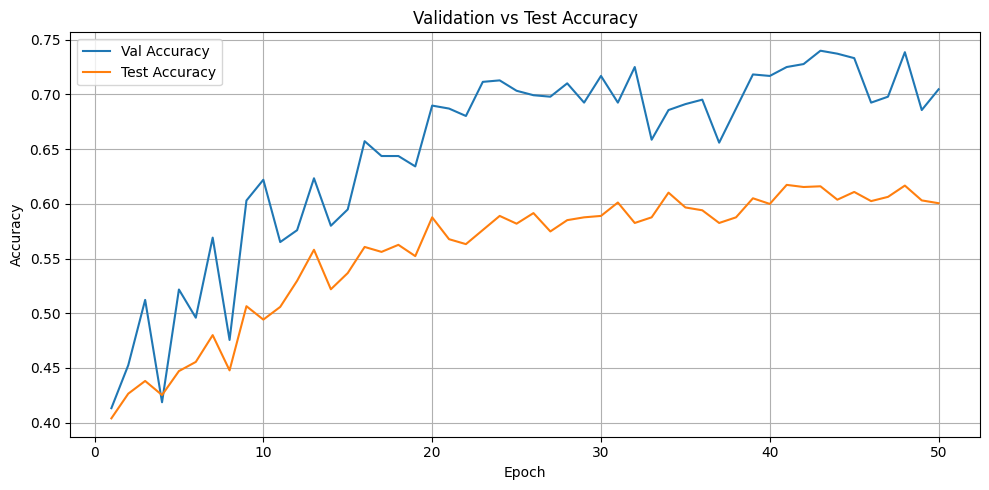


Best val acc: 0.7398373983739838


C:\Users\franc\AppData\Local\Temp\ipykernel_7328\68579158.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, map_location=devic

TEST (best checkpoint) | loss 1.3590 acc 0.6160

Classification report:
              precision    recall  f1-score   support

     neutral     0.6275    0.6828    0.6540       227
       happy     0.6032    0.5623    0.5820       265
         sad     0.5655    0.5698    0.5677       265
       angry     0.7365    0.7698    0.7528       265
     fearful     0.5714    0.5434    0.5571       265
     disgust     0.5840    0.5774    0.5806       265

    accuracy                         0.6160      1552
   macro avg     0.6147    0.6176    0.6157      1552
weighted avg     0.6144    0.6160    0.6148      1552

Confusion matrix:
[[155  17  22   9   9  15]
 [ 24 149  12  23  39  18]
 [ 25  15 151   0  41  33]
 [ 10  20   4 204   5  22]
 [  8  28  49  15 144  21]
 [ 25  18  29  26  14 153]]


In [ ]:

# Grafico accuracy train vs val
epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, val_acc_hist, label="Val Accuracy")
plt.plot(epochs_range, test_acc_hist, label="Test Accuracy")
plt.title("Validation vs Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 7) test finale con best checkpoint
print("\nBest val acc:", best_val_acc)
model.load_state_dict(torch.load(best_path, map_location=device))

test_loss, test_acc = evaluate(model, test_loader, device)
print(f"TEST (best checkpoint) | loss {test_loss:.4f} acc {test_acc:.4f}")

# 8) report dettagliato
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = model(x).cpu()
        preds = logits.argmax(dim=1).numpy().tolist()
        y_pred.extend(preds)
        y_true.extend(y.numpy().tolist())

print("\nClassification report:")
#RAVDNESS 
# target_names = [IDX2LABEL[i] for i in range(8)]
target_names = [CREMA_IDX2LABEL[i] for i in range(6)]
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

print("Confusion matrix:")
print(confusion_matrix(y_true, y_pred))
